In [2]:
%matplotlib inline
import numpy as np
from scipy import integrate
from scipy.special import gamma
from scipy.optimize import fsolve, basinhopping
from scipy.stats import logistic
from scipy import signal
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy.io
import scipy.interpolate
import gc
import datetime
import math
import uuid
import os
import time
import random
import matplotlib
import threading
from matplotlib import animation
import signal
import ipyparallel
#matplotlib.pyplot.switch_backend('nbAgg')
#%qtconsole

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
gcoll = 44.8#2*9.5*np.pi #HWHM
q = 1.39
quali = 892
fr = 3.4892e3;
kappa = np.pi*fr/quali #HWHM
deltas = 0 #detuning spins - cavity ws-wc in frequency
deltac = 0*2*np.pi
gperp = 2*np.pi*0.09 #HWHM
gpar = 2*np.pi*.001#0.001 #HWHM
gammaq = 2*np.pi*9.4 #FWHM
nbins = 701#701#5000#20
#g0 = gcoll/sqrt(nspins)
print(kappa)

12.288839783526353


In [4]:
def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = integrate.odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [5]:
def tsallis(f, q, width):
    delta = (width)/2*np.sqrt(2*q-2)/np.sqrt(2**q-2)/np.sqrt(2)
    norm = np.sqrt(q-1)*gamma(1/(q-1))/(np.sqrt(2*np.pi)*delta*gamma((3-q)/(2*(q-1))))
    val = (1+(q-1)*f**2/delta**2/2)**(1/(1-q))
    return norm*val

In [6]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

def find_nearest_sorted(array,value):
    """much faster for sorted arrays"""
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx
    
def find_nearest_sorted_left(array,value):
    """much faster for sorted arrays"""
    idx = np.searchsorted(array, value, side="left")
    if idx < len(array):
        diff = math.fabs(value - array[idx])
    else:
        diff = None
    if idx == 0 or diff == 0:
        return idx
    else:
        return idx - 1

def cauchy(x, pos, fwhm, ampl):
    return 1/((x-pos)**2+0.25*fwhm**2)*0.25*fwhm**2*ampl


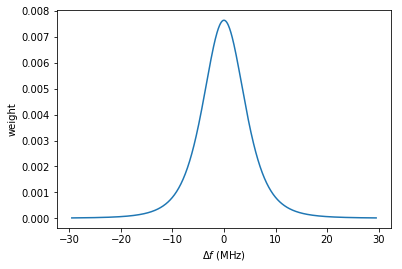

In [7]:
holes = False #set to true if you want to include holes in your simulation
inhomo = True #do you want inhomogneous broadening

f = np.linspace(-gammaq/2, gammaq/2, nbins )
pdf = tsallis(f, q, gammaq/2/np.pi)


if holes:
    frequency_exclude = gcoll/2/np.pi
    exclude_width = 0.2 #FWHM

    indf, freq = find_nearest(f, frequency_exclude)
    scale = pdf[indf]

    toex = cauchy(f, frequency_exclude, exclude_width, -scale)+cauchy(f, -frequency_exclude, exclude_width, -scale)
    #toex2 = cauchy(f, 0, exclude_width, -pdf[int(len(f)/2)])
    pdf = pdf+toex

pdf = np.clip(pdf, 0, max(pdf) )   
    
spdf = sum(pdf)
pdf = pdf/spdf    

if not inhomo:
    pdf = np.zeros(np.shape(pdf))
    pdf[int(nbins/2)] = 1
    
spins = f + deltas#draw samples according to distribution
gs = np.sqrt(pdf)*gcoll
plt.figure()
plt.plot(f, pdf)
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight');
#%qtconsole

In [8]:
def func(a, eta, deltdrive, g=None):
    if g is None:
        g = gs
    spins2 = 2*np.pi*(spins)+deltdrive

    s1 = 2*a*g**2
    s2 = gpar+2*gperp+2*1j*spins2
    s3 = 8*(gpar+2*gperp)*np.abs(a)**2*g**2
    s4 = gpar*((gpar+2*gperp)**2+4*spins2**2)
    
    s = s1/(s2*(-1-s3/s4))
    
    ret = -1j*a*deltdrive + eta - a*kappa + np.sum(s)
    return ret.real, ret.imag

def a_steady(eta, deltadrive, init):

    def equations(x):
        ar, ai = x
        return func(ar+1j*ai, eta, deltadrive)
    ar, ai = fsolve(equations, init)

    return ar, ai

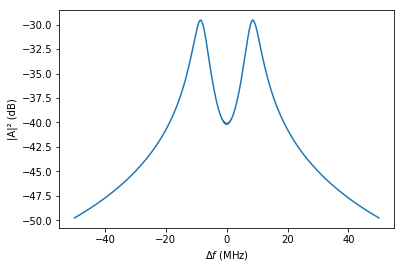

In [9]:
initsteady = (0.1,0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)');
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

In [37]:
#this is as optimized as possible using numpy slicing so calling this function SHOULD be very fast
ret = np.zeros(nbins*2+1, dtype=complex)

#@jit
def mbes(Y, t, eta):
    ret[0] = -kappa*Y[0]-1j*deltac*Y[0]+np.sum(gs*Y[1::2])+eta
    ret[1::2] = -(gperp+gpar/2 + 1j*(spins*2*np.pi+deltac))*Y[1::2]+gs*Y[2::2]*Y[0]
    ret[2::2] = -gpar*(1+Y[2::2])-2*gs*(Y[1::2]*np.conj(Y[0])+np.conj(Y[1::2])*Y[0])
    return ret

#%%timeit gives
#10000 loops, best of 3: 45 µs per loop
#for 800 spins it becomes ~70µs. This is probably not the bottleneck


#this function is a lot slower, so be careful when using it
#@jit
def mbes_soc(Y, t, ilist, qlist, tlist):
    idx = find_nearest_sorted_left(tlist, t)
    ret[0] = -kappa*Y[0]-1j*deltac*Y[0]+np.sum(gs*Y[1::2])+ilist[idx]-1j*qlist[idx]
    ret[1::2] = -(gperp+gpar/2 +1j*(spins*2*np.pi+deltac))*Y[1::2]+gs*Y[2::2]*Y[0]
    ret[2::2] = -gpar*(1+Y[2::2])-2*gs*(Y[1::2]*np.conj(Y[0])+np.conj(Y[1::2])*Y[0])
    return ret

def mbes_soc2(Y, t, fcomps, wgrund,  offseti, offsetq):
    pi = (pulse_rwa(t, [wgrund, fcomps[:,0], offseti]))
    pq = (pulse_rwa(t, [wgrund, fcomps[:,1], offsetq]))
    ret[0] = -kappa*Y[0]-1j*deltac*Y[0]+np.sum(gs*Y[1::2])+pi-1j*pq
    ret[1::2] = -(gperp+gpar/2 +1j*(spins*2*np.pi+deltac))*Y[1::2]+gs*Y[2::2]*Y[0]
    ret[2::2] = -gpar*(1+Y[2::2])-2*gs*(Y[1::2]*np.conj(Y[0])+np.conj(Y[1::2])*Y[0])
    return ret


In [38]:
def do_calculation(drive, tlistpump, tlistafter, init):

    #this should be very fast as well because scipy uses fortran 
    asolpump, infodict = odeintz(mbes, init, tlistpump, args=(drive,), full_output=True)
    init2 = asolpump[-1,:]
    asoldecay = odeintz(mbes, init2, tlistafter, args=(0,))
    
    #this is necessary because we are clustering the spins
    asolpump[:,2::2] = asolpump[:,2::2]*pdf
    asolpump[:,1::2] = asolpump[:,1::2]*pdf
    asoldecay[:,2::2] = asoldecay[:,2::2]*pdf
    asoldecay[:,1::2] = asoldecay[:,1::2]*pdf
    return asolpump, asoldecay, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...

    
def do_calculation_soc_awg(ilist, qlist, tlistp, tlistpump, tlistafter, init):
    """this method is if you want to use shaped drive, which means that the drive-lists as i and q channels
    shape should be given as first arguments
    
    factor is the number by which one has to multiply tlistpump, to get a all integer list as 0,1,2,3...numsteps-1
    """
    #this should be very fast as well because scipy uses fortran 
    asolpump, infodict = odeintz(mbes_soc, init, tlistpump, args=(ilist, qlist, tlistp), full_output=True)
    init2 = asolpump[-1,:]
    asoldecay = odeintz(mbes, init2, tlistafter, args=(0,))

    asolpump[:,2::2] = asolpump[:,2::2]*pdf
    asolpump[:,1::2] = asolpump[:,1::2]*pdf
    asoldecay[:,2::2] = asoldecay[:,2::2]*pdf
    asoldecay[:,1::2] = asoldecay[:,1::2]*pdf
    
    return asolpump, asoldecay, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...
    
def do_calculation_soc_pump_only_awg(ilist, qlist, tlist, init):
    """this method is if you want to use shaped drive, which means that the drive-lists as i and q channels
    shape should be given as first arguments
    
    it doesn't use a decay afterwards such that it is better for genetic algorithm
    
    factor is the number by which one has to multiply tlistpump, to get a all integer list as 0,1,2,3...numsteps-1
    """
    #this should be very fast as well because scipy uses fortran
    asol, infodict = odeintz(mbes_soc, init, tlist, args=(ilist, qlist, tlist), full_output=True)
    
    asol[:,2::2] = asol[:,2::2]*pdf
    asol[:,1::2] = asol[:,1::2]*pdf
    
    return asol, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...   
    
    
def do_calculation_soc(fourier, wgrund,  offseti, offsetq, tlistpump, tlistafter, init):
    """this method is if you want to use shaped drive, which means that the drive-lists as i and q channels
    shape should be given as first arguments
    
    factor is the number by which one has to multiply tlistpump, to get a all integer list as 0,1,2,3...numsteps-1
    """
    #this should be very fast as well because scipy uses fortran 
    asolpump, infodict = odeintz(mbes_soc2, init, tlistpump, args=(fourier, wgrund, offseti, offsetq), full_output=True)
    init2 = asolpump[-1,:]
    asoldecay = odeintz(mbes, init2, tlistafter, args=(0,))

    asolpump[:,2::2] = asolpump[:,2::2]*pdf
    asolpump[:,1::2] = asolpump[:,1::2]*pdf
    asoldecay[:,2::2] = asoldecay[:,2::2]*pdf
    asoldecay[:,1::2] = asoldecay[:,1::2]*pdf
    
    return asolpump, asoldecay, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...
    
def do_calculation_soc_pump_only(fourier, wgrund,  tlist, init):
    """this method is if you want to use shaped drive, which means that the drive-lists as i and q channels
    shape should be given as first arguments
    
    it doesn't use a decay afterwards such that it is better for genetic algorithm
    
    factor is the number by which one has to multiply tlistpump, to get a all integer list as 0,1,2,3...numsteps-1
    """
    #this should be very fast as well because scipy uses fortran
    asol, infodict = odeintz(mbes_soc2, init, tlist, args=(fourier, wgrund, offseti, offsetq), full_output=True)
    
    asol[:,2::2] = asol[:,2::2]*pdf
    asol[:,1::2] = asol[:,1::2]*pdf
    
    return asol, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...

In [39]:
filename = 'basinhopping_2018-08-14 11:37:58'
data = scipy.io.loadmat('/home/andreas/Physik/nelder_mead/%s.mat'%filename)
solution = data['solution']

tendp = float(data['time'][:,-1])
tendd = float(data['timedecay'][:,-1])*4

dt = 0.001

tpn = np.arange(0, tendp+dt, dt)
tdn = np.arange(0, tendd+dt, dt)

tall = np.hstack((tpn, tdn+tpn[-1]+dt))

init = np.ones(nbins*2+1)*(-1)
init[0] = 0
init[1::2] = 0
solutionpump, solutiondecay, info = do_calculation_soc_awg(data['pulse'][0], data['pulse'][1], data['time'][0,:], tpn, tdn, init)
solution = np.vstack((solutionpump, solutiondecay))

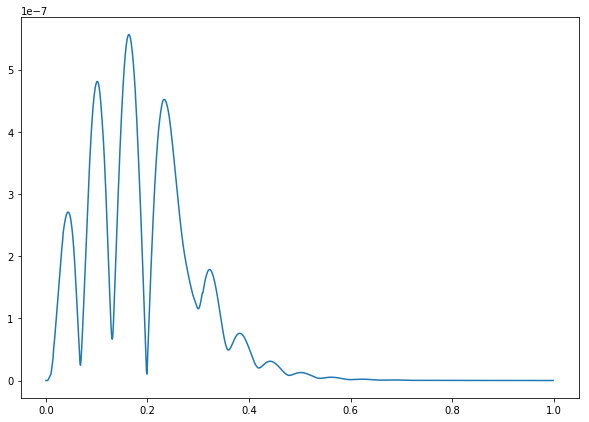

In [40]:

solutionpumplin, solutiondecaylin, info = do_calculation_soc_awg(data['pulse'][0]*1e-7, data['pulse'][1]*1e-7, data['time'][0,:], tpn, tdn, init)
solutionlin = np.vstack((solutionpumplin, solutiondecaylin))
fig = plt.figure(figsize=(10,7))
plt.plot(tall[:1000], np.abs(solutionlin[:1000,0]))

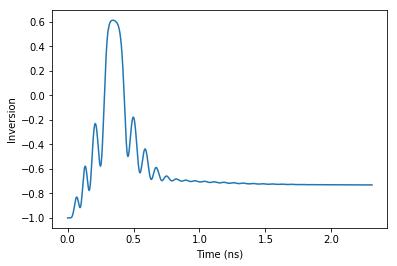

In [21]:

#plt.plot(abs(solution[:,0])**2)

szall = solution[:,2::2]
pl = np.real(np.sum(szall, axis=1))
idx = pl.argmax()

small = solution[:, 1::2]
alos = solution[:,0]
plt.plot(tall, np.real( np.sum(szall, axis=1)))

plt.xlabel('Time (ns)')
plt.ylabel('Inversion');

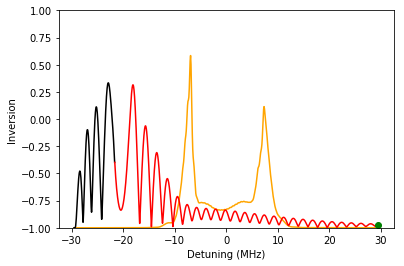

In [22]:
plt.close('all')
fig, ax = plt.subplots()
ax.set_xlabel('Detuning (MHz)')
ax.set_ylabel('Inversion')
ax.set_ylim([-1,1])
line1, = ax.plot(f, np.real(szall[0, :]))
#line2, = ax.plot(f, np.real(small[0, :]))
avals = (-1+2*abs(alos)/(1.5*max(abs(alos))))
tr = np.linspace(f[0], f[-1], len(tall))
line1.set_color('orange')
ax.plot(tr[:len(tpn)], avals[:len(tpn)], 'k')
ax.plot(tr[len(tpn):], avals[len(tpn):], 'r')
point, = ax.plot(tr[0], avals[0] , 'go')


def animate(i):
    line1.set_ydata(np.real(szall[i,:])/pdf)
    #line2.set_ydata(np.real(small[i,:])/pdf)
    point.set_xdata(tr[i])
    point.set_ydata(avals[i])
    return line1, point,


# Init only required for blitting to give a clean slate.
def init():
    line1.set_ydata(np.real(szall[0,:]/pdf))
    #line2.set_ydata(np.real(small[0,:]/pdf))
    point.set_ydata(avals[0])
    point.set_xdata(tr[0])
    return line1, point,



ani = animation.FuncAnimation(fig, animate, np.arange(1, len(tall)), init_func=init,
                              interval=10, blit=True)
ax.set_xlabel('Detuning (MHz)')
ax.set_ylabel('Inversion');
Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, bitrate=4800)
ani.save('/home/andreas/Physik/nelder_mead/%s.mp4'%filename, writer=writer)